# Generate filmstrip plots of change through time <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Background

Understanding how natural and human landscapes have changed through time can provide vital information about the health of local ecosystems and development of the built environment. 
For example, data on changes in the distribution of vegetation in the landscape can be used to monitor the impact of deforestation, or track the recovery of forests after habitat restoration or extreme natural events (e.g. bushfires). 
Tracking changes within urban areas can be used monitor the growth of infrastructure such as ports and transport networks, while data on coastal changes can be vital for predicting and managing the impacts of coastal erosion or the loss of coastal wetlands (e.g. mangroves).

Although these examples of change can be tracked using direct on-the-ground monitoring (e.g. vegetation surveys), it can be extremely challenging and expensive to obtain a comprehensive understanding of these processes at a broader landscape scale. 
For many applications, it can also be extremely useful to obtain a record of the history of a location undergoing change. 
This typically requires historical monitoring data which is unlikely to be available for all but the most intensively monitored locations.

### Digital Earth Australia use case

More than 30 years of satellite imagery from the [NASA/USGS Landsat program](https://www.usgs.gov/land-resources/nli/landsat) is freely available for Australia, making this a powerful resource for monitoring natural and human-driven change across the Australian continent.
Because these satellites image every location over Australia regularly (approximately once every 16 days), they provide an unparalleled archive of how many of Australia's landscapes have changed through time.

Analysing change from individual satellite images can be made difficult by the presence of clouds, cloud shadow, sunglint over water, and dynamic processes like changing tides along the coastline. 
By combining individual noisy images into cleaner "summary" images that cover a longer time period (e.g. one or multiple years), we can obtain a clear, consistent view of the Australian environment that can be compared to reveal changes in the landscape over time.


## Description
In this example, Digital Earth Australia Landsat data is extracted for a given time range and location, and combined using the geometric median ("geomedian") statistic to reveal the median or 'typical' appearance of the landscape for a series of time periods (for more information about geomedians, see the [Geomedian composites notebook](../Frequently_used_code/Geomedian_composites.ipynb)).

For coastal applications, the analysis can be customised to select only satellite images obtained during a specific tidal range (e.g. low, average or high tide). 

The results for each time period are combined into a 'filmstrip' plot which visualises how the landscape has changed in appearance across time, with a 'standard deviation' panel highlighting potential areas of greatest change:

![Example of filmstrip plot](../Supplementary_data/Change_filmstrips/filmstrip_example.JPG)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages used for the analysis.

In [1]:
%matplotlib inline

import sys
from datacube.helpers import write_geotiff

sys.path.append('../Scripts')
from notebookapp_changefilmstrips import run_filmstrip_app

%load_ext autoreload
%autoreload 2


### Analysis parameters

The following cell sets important required parameters for the analysis:

* `output_name`: A name that will be used to name the output filmstrip plot file
* `time_range`: The date range to analyse (e.g. `time_range = ('1988-01-01', '2007-12-31')`)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare (e.g. `time_step = {'years': 5}` will generate one filmstrip plot for every five years of data in the dataset; `time_step = {'months': 18}` will generate one plot for each 18 month period etc.
Time periods are counted from the first value given in `time_range`.

Optional parameters:

* `max_cloud`: This parameter allows you to exclude satellite images with excessive cloud. 
The default is `50`, which will keep all images with less than 50% cloud.
* `resolution`: The spatial resolution to load data. 
The default is `resolution = (-30, 30)`, which will load data at 30 m pixel resolution. 
Increasing this (e.g. to `resolution = (-100, 100)`) can be useful for loading large spatial extents.
* `tide_range`: This parameter allows you to generate filmstrip plots based on specific ocean tide conditions.
This can be valuable for analysing change concistently along the coast. 
For example, `tide_range = (0.0, 0.2)` will select only satellite images acquired at the lowest 20% of tides; `tide_range = (0.8, 1.0)` will select images from the highest 20% of tides. 
The default is `tide_range = (0.0, 1.0)` which will select all images regardless of tide.

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. 


In [2]:
# Required parameters
output_name = 'example'
time_range = ('1988-01-01', '2007-12-31')
time_step = {'years': 5}

# Optional parameters
max_cloud = 50
resolution = (-30, 30)
tide_range = (0.0, 1.0)

## Select location and generate filmstrips
Run the following cell to start the analysis. 
This will plot an interactive map that is used to select the area to load satellite data for.

Select the `Draw a rectangle` or `Draw a polygon` tool on the left of the map, and draw a shape around the area you are interested in (e.g. try drawing a rectangle around Sydney Airport and Port Botany to see an example of change driven by urban and coastal development).

When you are ready, press the green `done` button on the top right of the map. 
This will start loading the data, and then generate a filmstrips plot.

> Depending on the size of the area you select, this step can take **several minutes to complete**.
To keep load times reasonable, select an area **smaller than 100 square kilometres** in size (this limit can be overuled by supplying the `size_limit` parameter in the `run_filmstrip_app` function below).

> To check the status of the data load, click the **Dashboard** link under **Client** below.


Client Scheduler: tcp://127.0.0.1:37339 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 60.42 GB


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Loading ga_ls5t_ard_3 data
    Applying pixel quality mask
Loading ga_ls7e_ard_3 data
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    No data for ga_ls8c_ard_3
Combining and sorting data
Masking out invalid values
    Returning 309 observations as a dask array

Generating geomedian composites and plotting filmstrips... (this may take several minutes)


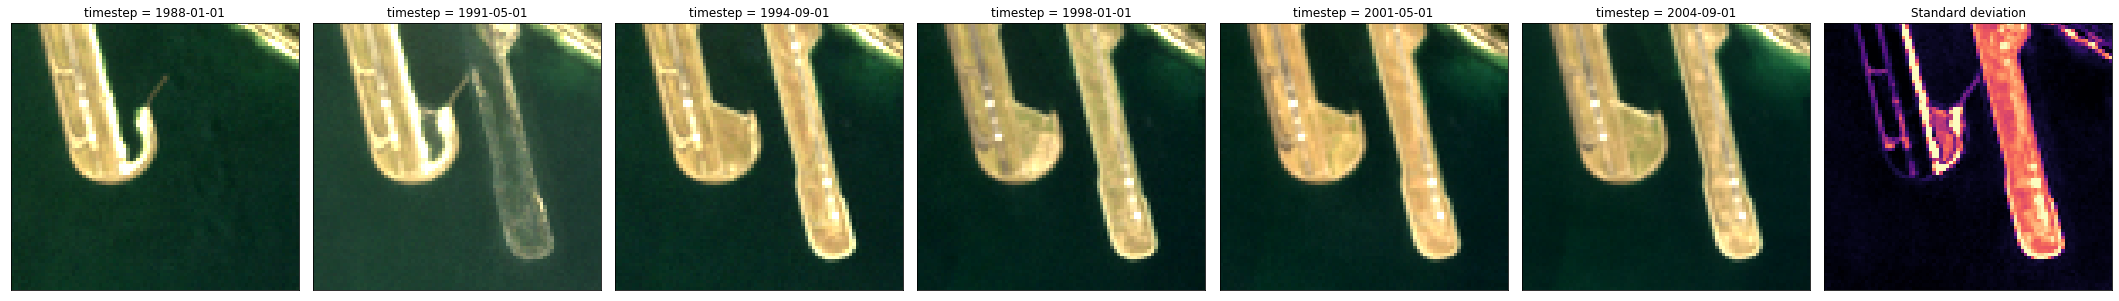

In [4]:
output_data = run_filmstrip_app(output_name,
                                time_range,
                                time_step,
                                tide_range,
                                max_cloud,
                                resolution)

## Downloading filmstrip plot
The high resolution version of the filmstrip plot generated above will be saved to the same location you are running this notebook from (e.g. typically `Real_world_examples`). 
In JupyterLab, use the file browser to locate the image file with a name in the following format: 

`filmstrip_{output_name}_{date_string}_{time_step}.png`

To download the image to your PC, right click on the image file and select `Download`.

## Export GeoTIFF data
It can be useful to export each of the time steps generated above as GeoTIFF raster files so that they can be loaded into a Geographic Information System (GIS) software for further analysis.

To export the GeoTIFFs, run the following cell then right click on the files in the JupyterLab file browser and select `Download`.

In [5]:
for i, ds in output_data.groupby('timestep'):
    print(f'Exporting {i} data')
    write_geotiff(dataset=ds, filename=f'geotiff_{output_name}_{i}.tif')

Exporting 1988-01-01 data
Exporting 1991-05-01 data
Exporting 1994-09-01 data
Exporting 1998-01-01 data
Exporting 2001-05-01 data
Exporting 2004-09-01 data


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)